In [1]:
import os

from lxml import etree
import base64
from bs4 import BeautifulSoup
import re
from nltk.tokenize import RegexpTokenizer
from urllib.parse import urljoin
import pymorphy2
import string
from collections import Counter

import numpy as np

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

BYWEB_PATH = os.path.join('data', 'byweb_for_course')
STOPWORDS_EN = os.path.join('data', 'stopwords', 'english')
STOPWORDS_RU = os.path.join('data', 'stopwords', 'russian')

In [2]:
class Document:
    def __init__(self, raw):
        self.raw = raw

In [3]:
def pipeline(docs, foo_list):
    for foo in foo_list:
        def generator(docs, foo):
            for doc in docs:
                yield foo(doc)
        docs = generator(docs, foo)
    return docs

def generate_raw_docs(db_path):
    for file_name in tqdm(os.listdir(db_path)[:1]):
        file_path = os.path.join(db_path, file_name)
        root = etree.parse(file_path).getroot()
        for raw in root.getchildren():
            yield Document(raw)
            break

In [4]:
def decoded_doc(doc):
    doc.html, doc.url, doc.doc_id = \
        list(map(lambda x: x.text, doc.raw))
    doc.url = base64.urlsafe_b64decode(doc.url).decode('cp1251')
    doc.html = base64.b64decode(doc.html).decode('cp1251')
    return doc

In [5]:
def build_text(doc):
    soup = BeautifulSoup(doc.html, 'lxml')
    for script in soup(['script', 'style']):
        script.decompose()
    doc.text = soup.get_text()
    doc.text = re.sub('(<!--.*?-->)', '', doc.text, flags=re.DOTALL)
    return doc

In [6]:
def get_tokenize_foo():
    tokenizer = RegexpTokenizer(r'\w+')
    def tokenize(doc):
        doc.tokens = tokenizer.tokenize(doc.text)
        return doc
    return tokenize

In [7]:
def get_lemmatization_foo():
    analyzer = pymorphy2.MorphAnalyzer()
    def lemmatization(doc):
        doc.lemmed_tokens = list(map(lambda x: x.lower(), doc.tokens))
        doc.lemmed_tokens = list(map(lambda x: analyzer.parse(x)[0].normal_form, doc.lemmed_tokens))
        return doc
    return lemmatization

In [8]:
def find_links(doc):
    soup = BeautifulSoup(doc.html)
    for script in soup(["script", "style"]):
        script.decompose()
    
    doc.links = set()
    for link in soup.findAll('a'):
        link_url = link.get('href')
        if not link_url or link_url[0] == '#':
            continue
        try:
            link_url = urljoin(url, link_url)
            doc.links.add(link_url)
        except Exception:
            pass
        
    return doc

In [9]:
docs = pipeline(generate_raw_docs(BYWEB_PATH),
                [decoded_doc, build_text, get_tokenize_foo(), get_lemmatization_foo(), find_links])

doc_count = 0
content_byte_lens = []
content_word_lens = []
text_html_ratios = []

collection_dict = Counter()

for doc in docs:
    doc_count += 1
    content_byte_lens.append(len(doc.text))
    content_word_lens.append(len(doc.tokens))
    text_html_ratios.append(len(doc.text) / len(doc.html))
    
    collection_dict.update(doc.lemmed_tokens)

In [10]:
print('Count of docs: {}'.format(doc_count))

Count of docs: 1


Mean doc length in bytes: 1324.0


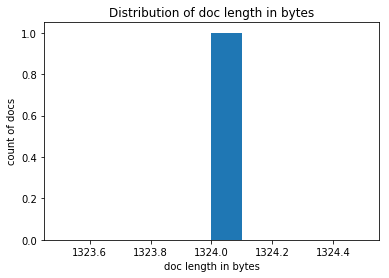

In [11]:
print('Mean doc length in bytes: {}'.format(np.array(content_byte_lens).mean()))

plt.hist(content_byte_lens)
plt.xlabel('doc length in bytes')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in bytes')
plt.show()

Mean doc length in words: 119.0


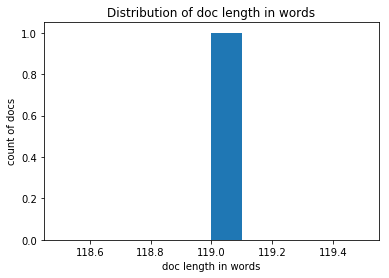

In [12]:
print('Mean doc length in words: {}'.format(np.array(content_word_lens).mean()))

plt.hist(content_word_lens)
plt.xlabel('doc length in words')
plt.ylabel('count of docs')
plt.title('Distribution of doc length in words')
plt.show()

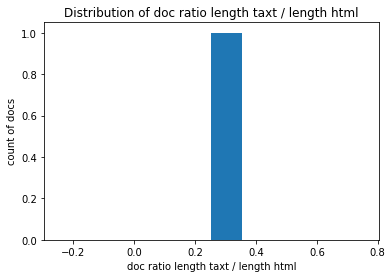

In [13]:
plt.hist(text_html_ratios)
plt.xlabel('doc ratio length taxt / length html')
plt.ylabel('count of docs')
plt.title('Distribution of doc ratio length taxt / length html')
plt.show()

In [14]:
stopwords = set([line.rstrip('\n') for file_path in [STOPWORDS_EN, STOPWORDS_RU]
                                   for line in open(file_path)])

collection_word_cnt = sum(collection_dict[w] for w in collection_dict)
collection_stopword_cnt = sum(w in stopwords for w in collection_dict)

print('{} words of {} words in all collection are stop-words'.format(
    collection_stopword_cnt, collection_word_cnt))
print('That is {:.4}%'.format(100 * collection_stopword_cnt / collection_word_cnt))

5 words of 119 words in all collection are stop-words
That is 4.202%


In [15]:
alphabet = set(list(string.ascii_lowercase))
def is_latin(word):
    return len(list(filter(lambda c: c not in alphabet, word))) == 0

collection_latinword_cnt = sum(int(is_latin(w)) for w in collection_dict)

print('{} words of {} words in all collection are latin-words'.format(
    collection_latinword_cnt, collection_word_cnt))
print('That is {:.4}%'.format(100 * collection_latinword_cnt / collection_word_cnt))

36 words of 119 words in all collection are latin-words
That is 30.25%


In [16]:
collection_word_sum_len = sum(len(w) * collection_dict[w] for w in collection_dict)
dict_word_sum_len = sum(len(w) for w in collection_dict)

print('Mean length of word in all collection is: {}'.format(collection_word_sum_len / collection_word_cnt))
print('Mean length of word in dictionary is: {}'.format(dict_word_sum_len / len(collection_dict)))

Mean length of word in all collection is: 4.630252100840337
Mean length of word in dictionary is: 5.271186440677966
